### Imports:

In [1]:
%matplotlib inline
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import arviz as az
import theano
from sklearn.metrics import r2_score

plt.style.use('seaborn-darkgrid')

Modelo

In [2]:
def SIR(y, t, p):
    dt = (1 - y[0])*p[0]*p[1]*(y[0])**p[2] + y[0]*p[0]*(1-p[1])*(1-y[0])**p[2]
    return [dt]

Testando os dados do modelo:

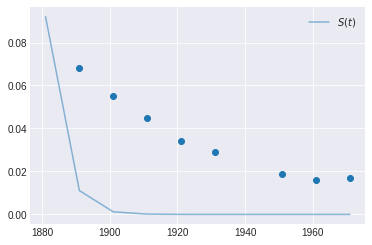

In [92]:
times = np.array([1881, 1891, 1901, 1911, 1921, 1931, 1951, 1961, 1971])


# Gerando curvas simuladas
y = odeint(SIR, y0=[0.092], t=times, args=((-0.22, 0.8, 1),), rtol=1e-8) # argumentos chutados
# dados (nesse caso ficticios)
yobs = np.array([[0.068], [0.055], [0.045], [0.034], [0.029], [0.019], [0.016], [0.017]])

plt.plot(times[1::], yobs, marker='o', linestyle='none')
plt.plot(times, y[:], color='C0', alpha=0.5, label=f'$S(t)$')
plt.legend();

Definindo o modelo:

In [93]:
sir_model = DifferentialEquation(
    func=SIR,
    times=np.array([1891, 1901, 1911, 1921, 1931, 1951, 1961, 1971]),
    n_states=1,
    n_theta=3,
    t0=1881,
)

yobs = np.array([[0.068], [0.055], [0.045], [0.034], [0.029], [0.019], [0.016], [0.017]])

Estimação dos parametro (c, s e a):

In [ ]:
with pm.Model() as model4:
    sigma = pm.HalfCauchy('sigma', 1, shape=1)

    # Distribuições a priori (lower liminf, upper limsup)
    R0 = pm.Bound(pm.Normal, lower=1)('R0', 2, 3)
    c = pm.Uniform('c', -3, 0)
    s = pm.Uniform('s', 0, 1)
    a = pm.Uniform('a', 0, 6)
    t0 = pm.Uniform('t0', 0, 1)
    
    sir_curves = sir_model(y0=[t0], theta=[c, s, a])

    Y = pm.Lognormal('Y', mu=pm.math.log(sir_curves), sigma=sigma, observed=yobs)
#    db = pm.backends.HDF5('traces.h5') # Salva as amostras e assim evita de manter tudo na memória
    trace = pm.sample(5000, tune=2500, start={'R0': np.array(2), 'c': np.array(-0.5), 'sigma': np.array([1]), 's': np.array(0.5), 'a': np.array(2)})

/tmp/ipykernel_2837/1254916709.py:15: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, tune=2500, start={'R0': np.array(2), 'c': np.array(-0.5), 'sigma': np.array([1]), 's': np.array(0.5), 'a': np.array(2)})
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t0, a, s, c, R0, sigma]


/usr/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1957614726382D+04   r2 =                  NaN


/usr/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1961197453397D+04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1914057552984D+04   r2 =                  NaN


/usr/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1890798616056D+04   r2 =                  NaN


Dados da estimação dos parametros:

In [ ]:
data = az.from_pymc3(trace=trace)
data

Posteriori dos parametros

In [ ]:
az.plot_posterior(data, round_to=2, hdi_prob=0.06);

In [ ]:
az.plot_trace(trace);

Modelagem do Gaelic

[[0.097     ]
 [0.07416598]
 [0.05904185]
 [0.04843641]
 [0.04066421]
 [0.03476651]
 [0.0264885 ]
 [0.02349665]
 [0.02102151]]


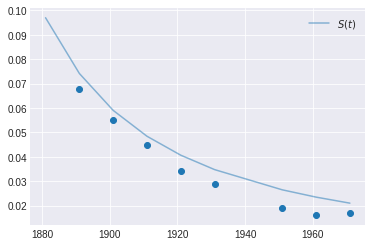

In [95]:
y = odeint(SIR, y0=[0.097], t=times, args=((-0.2, 0.99, 1.8),), rtol=1e-8)
print(y)

plt.plot(times[1::], yobs, marker='o', linestyle='none')
plt.plot(times, y[:], color='C0', alpha=0.5, label=f'$S(t)$')
plt.legend();

O r2 do plot acima:

In [96]:
abs(r2_score(np.array([[0.068], [0.055], [0.045], [0.034], [0.029], [0.019], [0.016], [0.017]]), y[1::]))

0.8938845703759892

In [97]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Mon Nov 22 2021

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

theano    : 1.1.2
matplotlib: 3.4.2
numpy     : 1.21.2
pymc3     : 3.11.4
arviz     : 0.11.4

Watermark: 2.2.0

